# Employee Turn Over Prediction

## Plan

On this stage we will look at the goal of the project and understand what kind of problem we are trying to solve, this will allow us to find the right tools to tackle the problem.

Since we are trying to predict whether an employee will leave the company or not in the future, and find which featuress are the most relevant for this analysis, this is a **binary classification problem**, where the outcome can be either `stayed` or `left`.

For this type of problems there are several algorithms that could be a good fit for us to tackle our main question, we will try using **Logistict Regression**, **Decision Trees**, and **Random Forest** and compare them to see which have the best performance.

### Import Packages and Tools

In [1]:
# Import data manipulation libraries
import pandas as pd
import numpy as np

# Import data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

# Import evaluation libraries
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the data
data = pd.read_csv('/data/HR_comma_sep.csv')

In [3]:
# Dataset check
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [4]:
# Get data rows and columns
data.shape

(14999, 10)

The dataset have a total of 14999 rows and 10 columns.

---

## Analyze

On this stage we will review the dataset to understand what we are working with, making sure we clean and prepare our data for further analysis and modeling in futher steps.

### Data Preparation and Cleansing

**Dataset general information**

In [5]:
# Review dataset null counts and types by columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


The dataset does not seem to have any null values, and its grouped in 3 different data types:


*   Float (`satisfaction_level`,`last_evaluation`)
*   Integer (`number_project`,`average_montly_hours`, `time_spend_company`,`Work_accident`,`left`, `promotion_last_5years`)
*   String (`Department`,`salary`)

**Dataset descriptive statistics**

In [6]:
# Review dataset descriptive statistics
data.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


A first look, the data seems to indicate that the features are well balanced with some exceptions, some noticeble things to mention are:

* `test_spend_company` seem to be skewed to the right showed by the gap between the 75 percentile and the max value despite having a low variance, indicating possible outliers.
*  `average_montly_hours` despite having a mean value very close to its median, its standard deviation seems to be quite high, we should review it with more detail.
* `Work_accident`,`left` and `promotion_last_5years` seems to be boolean values
* The features names does not follow a unique naming pattern, we should standardize it.

**Standarizing features naming pattern**


In [7]:
# Lower case
data.columns = data.columns.str.lower()

# Fixing typos
data.columns = data.columns.str.replace('average_montly_hours', 'average_monthly_hours')
data.columns = data.columns.str.replace(' ', '_')

# Better names
data.columns = data.columns.str.replace('time_spend_company', 'tenure')

print(data.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'tenure', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')


**Check for missing values**

In [8]:
# Review missing values
data.isna().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_monthly_hours,0
tenure,0
work_accident,0
left,0
promotion_last_5years,0
department,0
salary,0


**Check for duplicated values**

In [9]:
# Review duplicated values
data.duplicated().sum()

3008

This shows that there are **3008** records that have the same values across all the columns, which is very unlikely to have happened by chance.

In [10]:
# Check sample of duplicated values
data[data.duplicated(keep=False)].sort_values(by=data.columns.tolist()).head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
30,0.09,0.62,6,294,4,0,1,0,accounting,low
12030,0.09,0.62,6,294,4,0,1,0,accounting,low
14241,0.09,0.62,6,294,4,0,1,0,accounting,low
71,0.09,0.77,5,275,4,0,1,0,product_mng,medium
12071,0.09,0.77,5,275,4,0,1,0,product_mng,medium


In [11]:
# Remove duplicated values
data_cleaned = data.drop_duplicates()

Review new dataframe without duplicated values

In [12]:
data_cleaned.shape

(11991, 10)

There are 11991 in our new dataset, which seems to match the amount we removed (14999 - 3008 = 11991).

**Check for outliers**

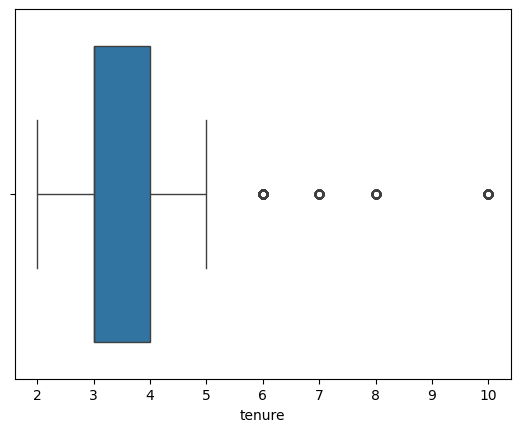

In [13]:
# Check outliers for Tenure
sns.boxplot(x=data_cleaned['tenure'])
plt.show()

There seems to be a few outliers based on the tenure feature.

---

### Exploratory Data Analysis

**Check target value balance within dataset**

In [14]:
# Reviewing the target column
print(data_cleaned['left'].value_counts())

# Review percentage distribution of the target column
print(data['left'].value_counts(normalize=True))

left
0    10000
1     1991
Name: count, dtype: int64
left
0    0.761917
1    0.238083
Name: proportion, dtype: float64


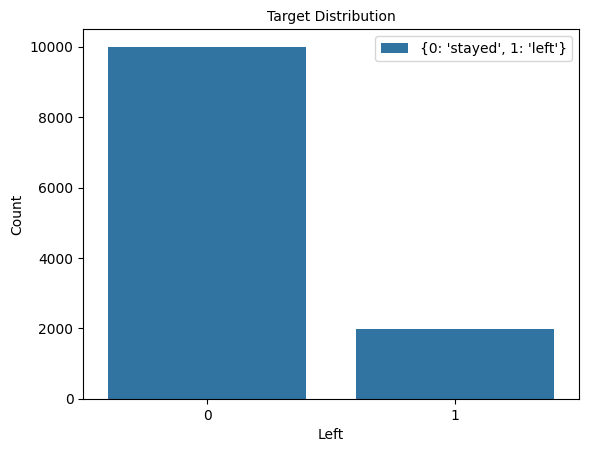

In [15]:
sns.countplot(data=data_cleaned, x='left')
plt.title('Target Distribution', fontsize=10)
plt.xlabel('Left', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend([{0:"stayed",1:"left"}])
plt.show()

The target value `left` have a proportion of 24% that **left** and 76% that **stayed**, its not the most balanced dataset for training a classification model but it should be still good for the purpose of our goal.

**Data Vizualization**

Our goal here is to understand the data and showcase it visually by asking ourself questions about the features and its correlation that may have contributed to a determined outcome of our target variable.

**Plot 1** - Satisfaction Level sounds like a logical benchmark to check if its related to the target variable.

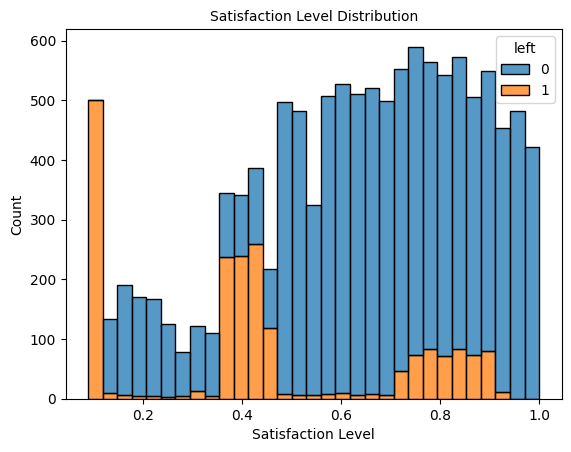

In [16]:
sns.histplot(data=data_cleaned, x='satisfaction_level', hue='left', multiple='stack')
plt.title('Satisfaction Level Distribution', fontsize=10)
plt.xlabel('Satisfaction Level', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

From the plot above we can see that within the employees that left, there are 3 groups:

*   The biggest group, left due to very low satisfaction.
*   The group that left and had moderate satisfaction level.
*   The group that left despite having high satisfaction level.

The biggest group make sense and suggest correlation between the variables, but the second and third group suggest that there may be other factors that contributed to the employees leaving and being fired.

To do:
*   Determine what is causing such low satisfaction level.
*   Determine what other factors are contributing to turnover despite high satisfaction.



**Plot 2** - Long working hours could also be a reason for employees turnover.

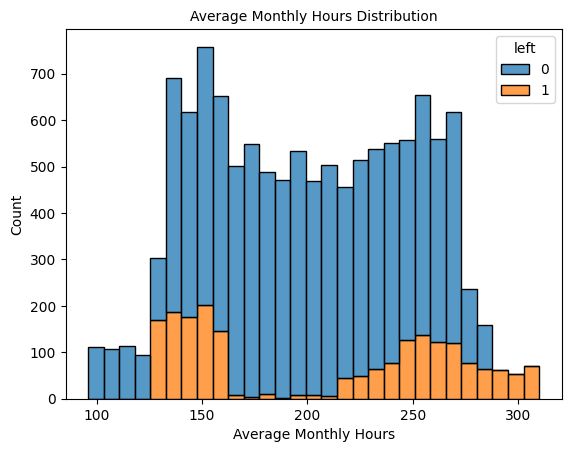

In [17]:
sns.histplot(data=data_cleaned, x='average_monthly_hours', hue='left', multiple='stack')
plt.title('Average Monthly Hours Distribution', fontsize=10)
plt.xlabel('Average Monthly Hours', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

From the plot above we can observe that the employees who left are separated into 2 groups:
* Have a below average_monthly_hours
* Have an above average_monthly_hours, reaching to outliers levels.

The first group could have been fired due to low working hours, and the second group could have quitted due to overwork.

**Plot 3** - Now lets check whether long working hours had and effect on satisfaction levels resulting in turnover.

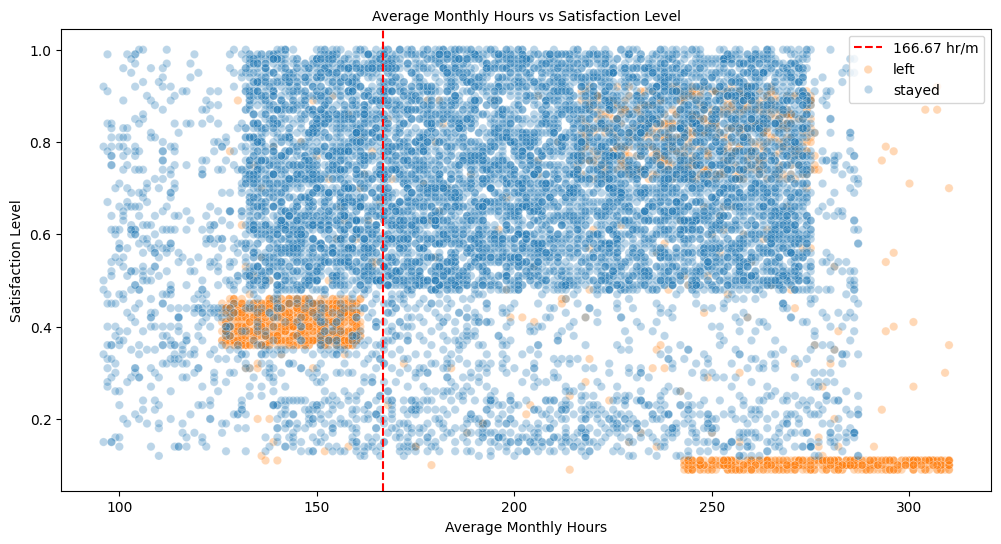

In [18]:
# Base plot configuration
plt.figure(figsize=(12, 6))
plt.title('Average Monthly Hours vs Satisfaction Level', fontsize=10)
plt.xlabel('Average Monthly Hours', fontsize=10)
plt.ylabel('Satisfaction Level', fontsize=10)

### Lets use the industry average monthly working hours as a benchmark for our plot
# total = 52 wk/yr, offdays = 2 wk/yr, work_week = 50 wk/yr, work_days_week = 5 dy/wk, work_hours_days = 8 hr/dy
# work_hour_week = 40 hr/wk , work_hour_year = 40 hr/wk x 50 wk = 2000 hr/yr
# 2000 hr/yr across 12 months = 166.67 hr/month
plt.axvline(x=166.67,label='166.67 hr/m', color='r', ls='--')

# Plotting
sns.scatterplot(data=data_cleaned,x='average_monthly_hours', y='satisfaction_level', hue='left',alpha=0.3)

# Add legends that include the line for benchmark
plt.legend(labels=['166.67 hr/m','left','stayed'])

plt.show()

The plot above seems to confirm a similar trend as the previous plot, where there are 3 group of employees that left/fired:
* the group with significantly more average monthly hours (240-320) but extremently low satisfaction level (less than 0.2).
* the group with moderately high average monthly hours (210-275) but with a satisfaction level of 0.7 to 0.9
* the group with below the standard average monthly hours we setup but also below median satisfaction level.

One may use this and infer that the first group left due to overwork, the second group would require further investigation to understand the reason for the pattern, and the third group may have been fired for working less than average monthly hours or left the company due to pressure of working more hours.

**Plot 4** - Lets check the relationship between working hours and the number of project assigned to employees, using a boxplot and a histogram.

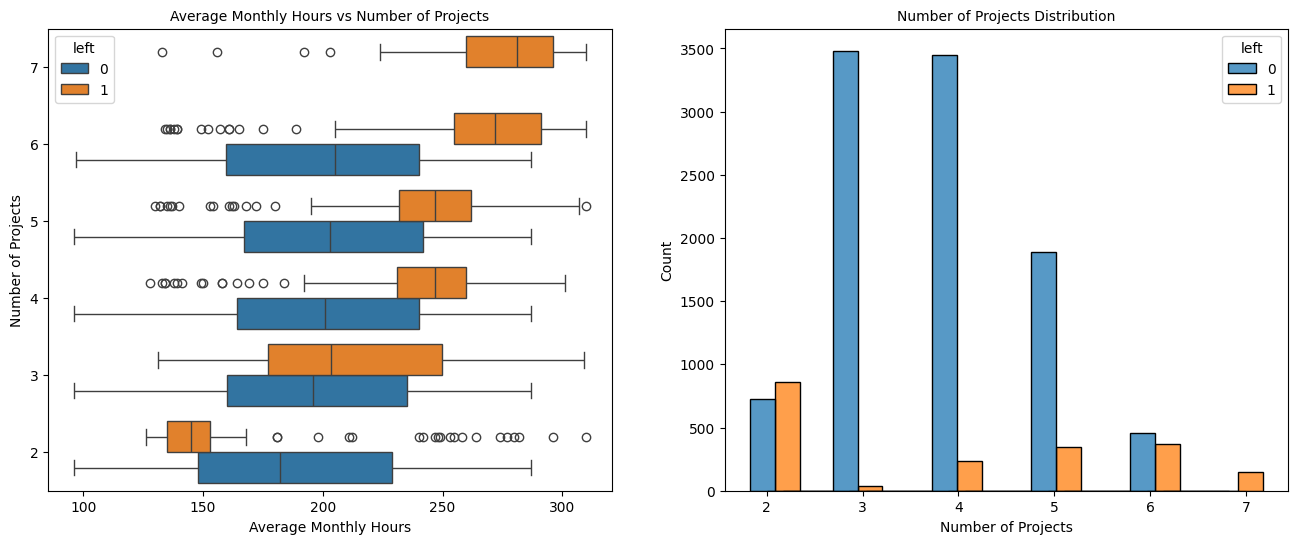

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,6))
#plot 1
sns.boxplot(data=data_cleaned,x='average_monthly_hours',y='number_project',hue='left',orient='h',ax=ax[0])
ax[0].set_title('Average Monthly Hours vs Number of Projects', fontsize=10)
ax[0].set_xlabel('Average Monthly Hours', fontsize=10)
ax[0].set_ylabel('Number of Projects', fontsize=10)
ax[0].invert_yaxis()

#plot 2
sns.histplot(data=data_cleaned,x='number_project',hue='left',multiple='dodge',shrink=3, ax=ax[1])
ax[1].set_title('Number of Projects Distribution', fontsize=10)
ax[1].set_xlabel('Number of Projects', fontsize=10)

plt.show()

The plot above further confirms something obvious at first thought, which is the more project assigned someone have the more hours they worked, with the exception of some outliers. Some noticeble insights we should mention are:
* The mean monthly hours for those who didn't left seems to be around 200, which is still above industry numbers (166.67 hrs)
* Within the group of employees with 7 projects, everyone seems to have left.
* Within every group, even those who didn't left, worked noticeably more than the average hours (166.67 hrs)
* According to both plots, a well balance amount of project should be between 3 or 4.
* Within the employees with 2 projects assigned, a group that left worked much less on average than their peers with the same number of projects, this could let us infer that they were either let go due to this, or maybe they were getting ready to leave already.
* Based on the evidence so far, the company employees seem to be very overwork.

**Plot 5** - Now lets check if employees that contributed a lot of their time to the company did well in their last evaluation.

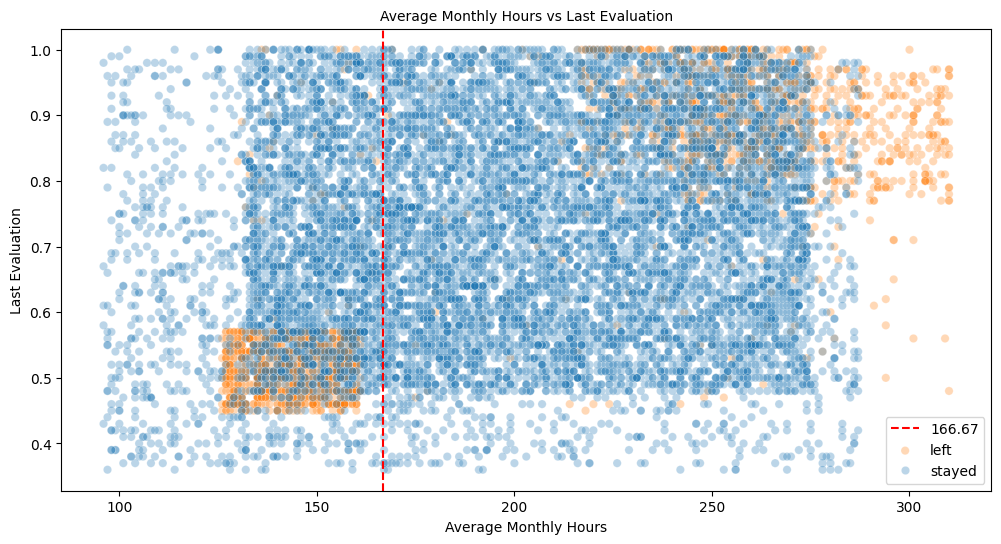

In [20]:
# Base Plot settings
plt.figure(figsize=(12,6))
plt.title('Average Monthly Hours vs Last Evaluation', fontsize=10)
plt.xlabel('Average Monthly Hours', fontsize=10)
plt.ylabel('Last Evaluation', fontsize=10)

# Average Hours Line
plt.axvline(x=166.67, label='166.67', color='r', ls='--')

# Plotting
sns.scatterplot(data=data_cleaned,x='average_monthly_hours',y='last_evaluation',hue='left',alpha=0.3)

# Add Legend
plt.legend(labels=['166.67','left','stayed'])

plt.show()

The plot above seems to indicate just as our **Plot 3** that most of the employees in the company work more than average hours. There seems to be 2 group of people that left based on this analysis:
* The group that worked significantly more that others and performed really well on their evaluation
* The group that worked less than average and performed poorly in their evaluation.

**Plot 6** - Lets check whether employees that contributed more time to the company were rewarded with incentives such as promotions.

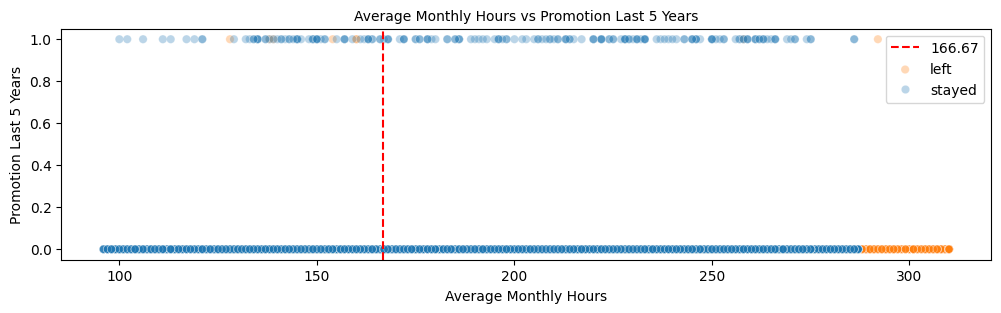

In [21]:
# Base plot setup
plt.figure(figsize=(12,3))
plt.title('Average Monthly Hours vs Promotion Last 5 Years', fontsize=10)
plt.xlabel('Average Monthly Hours', fontsize=10)
plt.ylabel('Promotion Last 5 Years', fontsize=10)

# Average work Line
plt.axvline(x=166.67, label="166.67",color='r', ls='--')

# Plotting
sns.scatterplot(data=data_cleaned,x='average_monthly_hours',y='promotion_last_5years',hue='left',alpha=0.3)

# Legends
plt.legend(labels=['166.67','left','stayed'])

plt.show()

The plot above seemst to indicate that:
* Most employees that worked more than 280 hours per month but weren't promoted left.
* For those who stayed, only a small portion were promoted in the last five years,despite working similar or more hours.

**Plot 7** - Now lets review seniority/tenure and its correlation with satisfaction level within the company, and also see how employees tenure is distributed within the company.

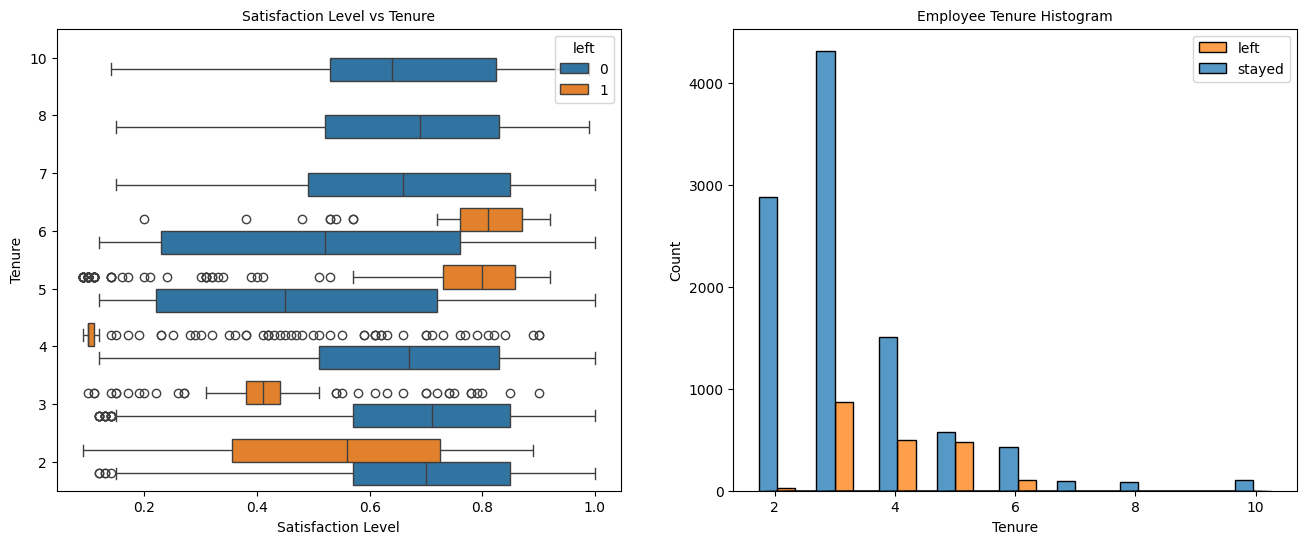

In [22]:
# Plot base setup
fig,ax = plt.subplots(1,2,figsize=(16,6))

# 01
ax[0].set_title('Satisfaction Level vs Tenure', fontsize=10)
ax[0].set_xlabel('Satisfaction Level', fontsize=10)
ax[0].set_ylabel('Tenure', fontsize=10)
sns.boxplot(data=data_cleaned,x='satisfaction_level',y='tenure',hue='left',orient='h',ax=ax[0])
ax[0].invert_yaxis()

# 02
ax[1].set_title("Employee Tenure Histogram",fontsize=10)
ax[1].set_xlabel("Tenure",fontsize=10)
sns.histplot(data=data_cleaned,x='tenure',hue='left',multiple='dodge',shrink=7,ax=ax[1])
ax[1].legend(labels=['left','stayed'])

plt.show()
# Plotting


The plot above suggest that:
* Employee with the most tenure dont have a tendency to leave the company, probably most of them are high ranking employees.
* New employees and long-term employess that didn't left shares similar satisfaction levels.
* Employees that have spent 4 years at the company with significant low level of satisfaction left.
* The plot also shows that dissatisfied employees that left, spent 2-6 years in the company with a satisfaction level around 0.2-0.6.

**Plot 8** - Now lets check the correlation between tenure and salary definition.

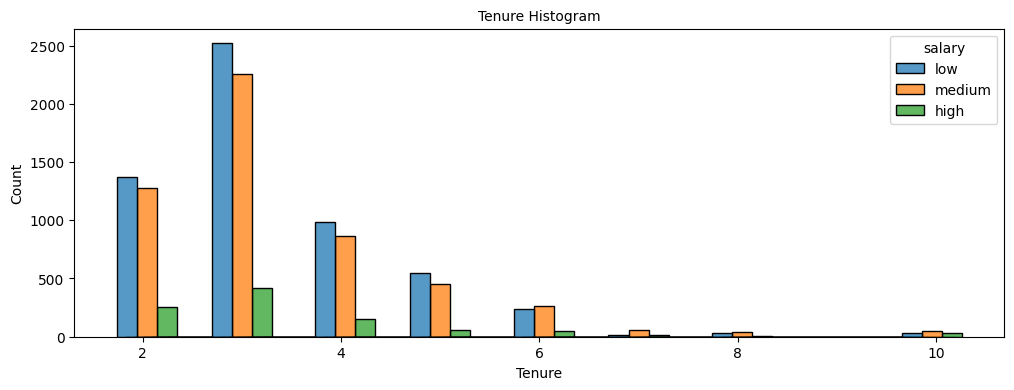

In [23]:
plt.figure(figsize=(12,4))
sns.histplot(data=data_cleaned,x='tenure',hue='salary',multiple='dodge',shrink=7)
plt.title('Tenure Histogram', fontsize=10)
plt.xlabel('Tenure', fontsize=10)

plt.show()

The plot above seems to show a consisten pattern between tenure and salary, the most salary category is low from 2-5 years terms, from 6 years or more, the common salary is medium tier.

**Plot 9** - Since we have the department feature, lets check if there is a correlation between department and employees who left.

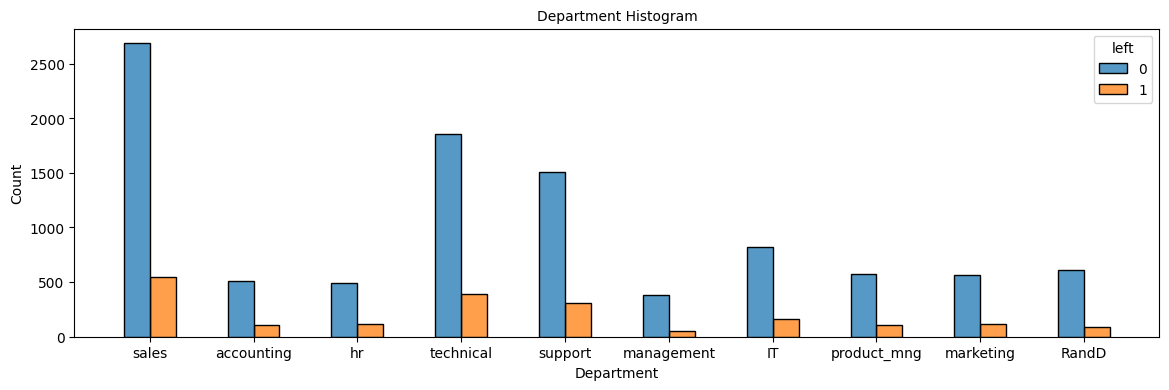

In [24]:
plt.figure(figsize=(14,4))
sns.histplot(data=data_cleaned,x='department',hue="left",multiple="dodge",shrink=0.5,hue_order=[0,1])
plt.title('Department Histogram', fontsize=10)
plt.xlabel('Department', fontsize=10)

plt.show()

The plot above shows a stable pattern where in most department there were employees who left.

**Plot 10** - Lets check with a correlation heatmap if there are any correlation we missed during our analysis.

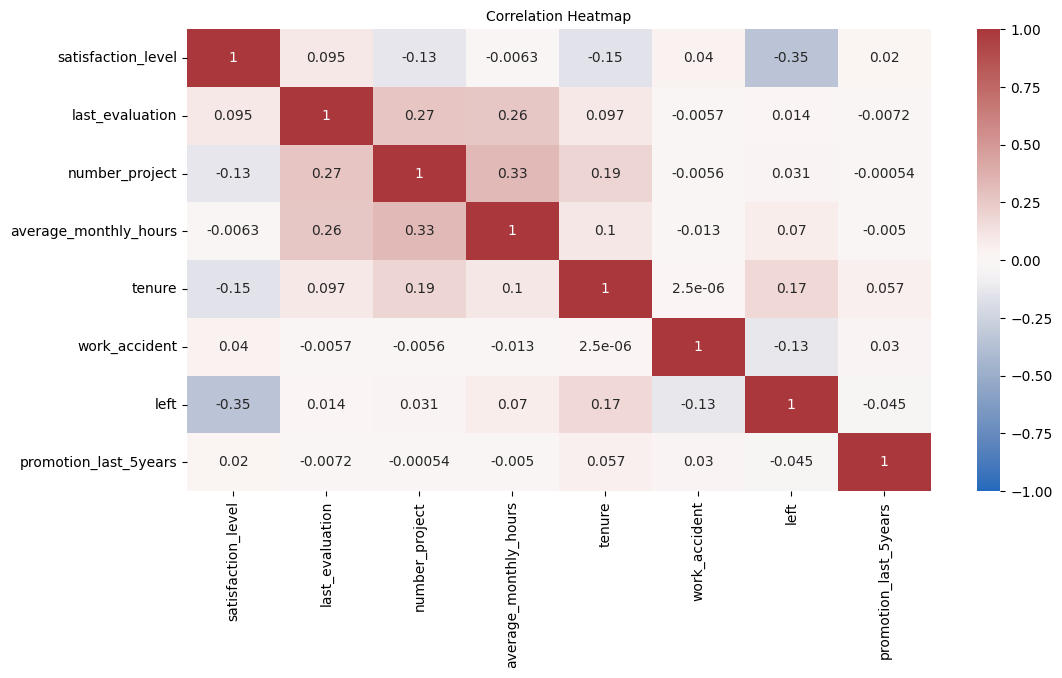

In [25]:
plt.figure(figsize=(12,6))
sns.heatmap(data=data_cleaned.corr(numeric_only=True), vmin=-1,vmax=1,annot=True, cmap=sns.color_palette('vlag', as_cmap=True))
plt.title('Correlation Heatmap', fontsize=10)
plt.show()

The plot above seems to indicate that satisfaction level have a negative correlation with whether an employee leaves. While last_evaluation, average_monthly_hours, number_of projects have some positive correlation with each other. This means that our previous plot analysis were done to the relevant features.

**General EDA Conclusion**

The general insight from these Data Visualization seems to indicate that the employees are leaving the company because they are burned out from working long hours on several number of projects which results to low level satisfaction. Another great suggestion maybe to promote employees with a moderate tenure to increase retention.

## Construct

In this phase we will determine determine the type of problem the model is trying to solve, which in this case is clearly a classification task, a **binary classification** prediction to be more specific, since we are trying to determine whether an employee left or not (1 or 0) from the provided dataset.

We have several models we could use and compare in order to determine which one is better suited for us.

*   Logistic Regression, sensible to outliers
*   Decision Tree, prone to overfitting
*   Random Forest, computationally expensive



### Model Building

#### Logistic Regression

In [26]:
# Separate the dataset in to features and target
y = data_cleaned['left']
X = data_cleaned.copy().drop(columns=['left'])

In [27]:
# Feature Encoding
# Salary - Ordinal
salary_mapping = {'low': 0, 'medium': 1, 'high': 2}
X['salary'] = X['salary'].map(salary_mapping)

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,0,sales,0
1,0.80,0.86,5,262,6,0,0,sales,1
2,0.11,0.88,7,272,4,0,0,sales,1
3,0.72,0.87,5,223,5,0,0,sales,0
4,0.37,0.52,2,159,3,0,0,sales,0


In [28]:
# Feature Enconding
# Department - Nominal
X = pd.get_dummies(X, columns=['department'])

X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [29]:
# Splitting the dataset into Training and Testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

In [30]:
# Instanciate model
logreg = LogisticRegression(random_state=1,)

In [31]:
# Gridsearch to find best set of hyperparameters
cv_parameters= {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100,1000]}
scoring=['accuracy','precision','recall','f1','roc_auc']
grid_logreg = GridSearchCV(logreg, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [32]:
# Training model with tuned hyperparameters.
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [33]:
grid_logreg.best_score_

0.8203830067413376

In [34]:
grid_logreg.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [35]:
grid_logreg.best_estimator_

LogisticRegression(C=0.1, random_state=1)

In [36]:
# General function to compare different models performance
def get_results(model_name:str, model_object, metric:str):
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })

    return table

In [37]:
tuned_logreg_result = get_results("Tuned Logistic Regression", grid_logreg, 'auc')
tuned_logreg_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression,0.493162,0.146681,0.224926,0.83287,0.820383


#### Decision Tree

In [38]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=1)

In [39]:
# Gridsearch to find best set of hyperparameters
cv_parameters= {
    'max_depth': [2, 6, 10, 14, 20, None],
    'min_samples_leaf': [2, 5, 8],
    'min_samples_split': [2, 6, 10],
}
scoring=['accuracy','precision','recall','f1','roc_auc']

grid_dt = GridSearchCV(decision_tree, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [40]:
# Training the model with the gridsearch setup
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [2, 6, 10, 14, 20, None],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2, 6, 10]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [41]:
grid_dt.best_score_

0.9714473584580968

In [42]:
grid_dt.best_params_

{'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 2}

In [43]:
grid_dt.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=1)

In [44]:
tuned_dt_result = get_results("Tuned Decision Tree", grid_dt, 'auc')
tuned_dt_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Decision Tree,0.969727,0.901515,0.934312,0.978983,0.971447


In [45]:
# Concatenate results to compare performance
tuned_model_results = pd.concat([tuned_logreg_result, tuned_dt_result])

In [46]:
tuned_model_results.head()

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression,0.493162,0.146681,0.224926,0.832870,0.820383
0,Tuned Decision Tree,0.969727,0.901515,0.934312,0.978983,0.971447


#### Random Forest

In [47]:
# Instantiate model
random_forest = RandomForestClassifier(random_state=1)

In [48]:
# Gridsearch to find the best hyperparameters
cv_parameters= {
    'max_depth': [2, 20, None],
    'min_samples_leaf': [2, 5, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 300],
    'max_samples': [0.7, 1.0],
    'max_features': [1.0]
}

scoring=['accuracy','precision','recall','f1','roc_auc']

grid_rf = GridSearchCV(random_forest, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [49]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [2, 20, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [50]:
grid_rf.best_score_

0.9794913410099287

In [51]:
grid_rf.best_params_

{'max_depth': 20,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 300}

In [52]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=20, max_features=1.0, max_samples=0.7,
                       min_samples_leaf=8, n_estimators=300, random_state=1)

In [53]:
tuned_rf_result = get_results("Tuned Random Forest", grid_rf, 'auc')
tuned_rf_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Random Forest,0.96757,0.902182,0.93366,0.97876,0.979491


In [54]:
tuned_model_results = pd.concat([tuned_model_results, tuned_rf_result])
tuned_model_results.head()

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression,0.493162,0.146681,0.224926,0.832870,0.820383
0,Tuned Decision Tree,0.969727,0.901515,0.934312,0.978983,0.971447
0,Tuned Random Forest,0.967570,0.902182,0.933660,0.978760,0.979491


### Model Selection
After reviewing the 3 options we tested on the training data, lets pick the one that performed the best and evaluate it on the testing set.

In [55]:
def get_scores(model_name:str,model_object,X_test,y_test):
  y_pred = model_object.best_estimator_.predict(X_test)

  auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)

  table = pd.DataFrame({
      'model': [model_name],
      'precision': [precision],
      'recall': [recall],
      'F1': [f1],
      'accuracy': [accuracy],
      'auc': [auc]
  })

  return table



In [56]:
rf_test_results = get_scores("Random Forest Test",grid_rf,X_test,y_test)
rf_test_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest Test,0.972574,0.925703,0.94856,0.983322,0.960251


### Model Evaluation

#### Confusion Matrix

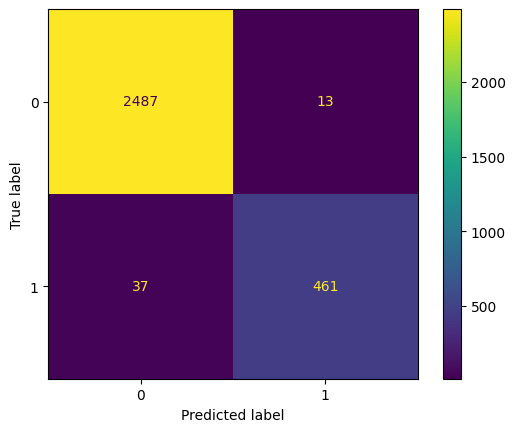

In [57]:
# Drawing a Confusion Matrix on the Testing Set Results to evaluate the model
y_pred = grid_rf.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=grid_rf.classes_)
cm_diplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_rf.classes_)
cm_diplay.plot()
plt.show()

#### Features Importance

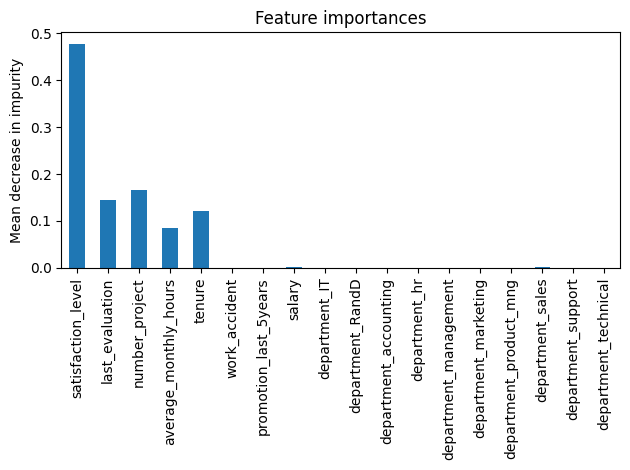

In [58]:
# Analyzing Feature importance within the model
importance = grid_rf.best_estimator_.feature_importances_

rf_importances = pd.Series(importance, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The plot above shows that `satisfaction_level`,`last_evaluation`, `number_project`, `tenure`, and `average_monthly_hours`, are the most important features which are variables very helpful in predicting the outcome variable `left`.

### Feature Engineering

The model performed pretty well, now lets look within our initial dataset to see if we can perform **feature engineering** in order to generate new and meaninful features to improve the performance of the model.

In [59]:
# Dropping Satisfaction Level as this is not a feature we will have always
data_feat_eng = data_cleaned.drop(columns=['satisfaction_level'])
data_feat_eng.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.53,2,157,3,0,1,0,sales,low
1,0.86,5,262,6,0,1,0,sales,medium
2,0.88,7,272,4,0,1,0,sales,medium
3,0.87,5,223,5,0,1,0,sales,low
4,0.52,2,159,3,0,1,0,sales,low


In [60]:
# Lets simplify the average monthly hours to just classify whether an employee is overworked or not.
data_feat_eng['overworked'] = data_feat_eng['average_monthly_hours']

# Checking the min and max average hours within the dataset
print("Max avg working hours:",data_feat_eng["overworked"].max())
print("Min avg working hours:",data_feat_eng["overworked"].min())

Max avg working hours: 310
Min avg working hours: 96


In [61]:
# Lets uses 175 hours as a benchmark to determine if an employee is overworked or not.
data_feat_eng['overworked'] = data_feat_eng['overworked'].apply(lambda x: 1 if x > 175 else 0).astype(int)

# Lets drop the old feature to avoid multi collinearity.
data_feat_eng = data_feat_eng.drop(columns=['average_monthly_hours'])

data_feat_eng.head()

,last_evaluation,number_project,tenure,work_accident,left,promotion_last_5years,department,salary,overworked
0,0.53,2,3,0,1,0,sales,low,0
1,0.86,5,6,0,1,0,sales,medium,1
2,0.88,7,4,0,1,0,sales,medium,1
3,0.87,5,5,0,1,0,sales,low,1
4,0.52,2,3,0,1,0,sales,low,0


### Model Building v2

Lets check how the model will perform after the feature engineering we did.

In [62]:
# Again, lets separate the new dataset into Features and Target.
y = data_feat_eng['left']
X = data_feat_eng.copy().drop(columns=['left'])

In [63]:
# Again, lets do the same feature encoding for the categorical data.

# Salary - Ordinal
salary_mapping = {'low': 0, 'medium': 1, 'high': 2}
X['salary'] = X['salary'].map(salary_mapping)

# Department - Nominal
X = pd.get_dummies(X, columns=['department'])

X.head()

,last_evaluation,number_project,tenure,work_accident,promotion_last_5years,salary,overworked,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,3,0,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,6,0,0,1,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,4,0,0,1,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,5,0,0,0,1,False,False,False,False,False,False,False,True,False,False
4,0.52,2,3,0,0,0,0,False,False,False,False,False,False,False,True,False,False


In [64]:
# Now separate the new dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

#### Logistic Regression v2

In [65]:
# Instantiate the model
logreg2 = LogisticRegression(random_state=1)

In [66]:
# Gridsearh to look for the best hyperparameters
cv_parameters= {'penalty':['l1','l2'],'C':[0.001,0.01,0.1,1,10,100,1000]}
scoring=['accuracy','precision','recall','f1','roc_auc']
grid_logreg2 = GridSearchCV(logreg2, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [67]:
# Train the model with the tuned hyperparameters
grid_logreg2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [68]:
grid_logreg2.best_score_

0.7368239979648792

In [69]:
grid_logreg2.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [70]:
grid_logreg2.best_estimator_

LogisticRegression(C=0.01, random_state=1)

In [71]:
# Getting the performance result of this new LogReg model
tuned_logreg2_result = get_results("Tuned Logistic Regression v2", grid_logreg2, 'auc')
tuned_logreg2_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression v2,0.0,0.0,0.0,0.827087,0.736824


#### Decision Tree v2

In [72]:
# Instantiate the model
decision_tree2 = DecisionTreeClassifier(random_state=1)

In [73]:
# Gridsearch for tuning hyperparameters
cv_parameters= {
    'max_depth': [2, 6, 10, 14, 20, None],
    'min_samples_leaf': [2, 5, 8],
    'min_samples_split': [2, 6, 10],
}
scoring=['accuracy','precision','recall','f1','roc_auc']
grid_dt2 = GridSearchCV(decision_tree2, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [74]:
# Train the model
grid_dt2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
             param_grid={'max_depth': [2, 6, 10, 14, 20, None],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2, 6, 10]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [75]:
grid_dt2.best_score_

0.9596419923234046

In [76]:
grid_dt2.best_params_

{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}

In [77]:
grid_dt2.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=2, min_samples_split=10,
                       random_state=1)

In [78]:
# Getting the model performance metrics
tuned_dt2_result = get_results("Tuned Decision Tree v2", grid_dt2, 'auc')
tuned_dt2_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Decision Tree v2,0.808462,0.902851,0.852572,0.948069,0.959642


In [79]:
# Comparing the model performance
tuned_model_results = pd.concat([tuned_logreg2_result, tuned_dt2_result])
tuned_model_results.head()

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression v2,0.000000,0.000000,0.000000,0.827087,0.736824
0,Tuned Decision Tree v2,0.808462,0.902851,0.852572,0.948069,0.959642


#### Random Forest v2

In [80]:
# Instantiate the model
random_forest2 = RandomForestClassifier(random_state=1)

In [81]:
# Gridsearch to find the best hyperparameters
cv_parameters= {
    'max_depth': [2, 20, None],
    'min_samples_leaf': [2, 5, 8],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 300],
    'max_samples': [0.7, 1.0],
    'max_features': [1.0]
}

scoring=['accuracy','precision','recall','f1','roc_auc']

grid_rf2 = GridSearchCV(random_forest2, cv_parameters, cv=5, scoring=scoring, refit="roc_auc")

In [82]:
# Train the model
grid_rf2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [2, 20, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [2, 5, 8],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [83]:
grid_rf2.best_score_

0.9646959671687132

In [84]:
grid_rf2.best_params_

{'max_depth': 20,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 300}

In [85]:
grid_rf2.best_estimator_

RandomForestClassifier(max_depth=20, max_features=1.0, max_samples=0.7,
                       min_samples_leaf=8, n_estimators=300, random_state=1)

In [86]:
# Getting new random forest model performance
tuned_df2_result = get_results("Tuned Random Forest v2", grid_rf2, 'auc')
tuned_df2_result

,model,precision,recall,F1,accuracy,auc
0,Tuned Random Forest v2,0.901557,0.885432,0.8932,0.964861,0.964696


In [87]:
# Comparing all new models after features engineering
tuned_model_results = pd.concat([tuned_model_results, tuned_df2_result])
tuned_model_results.head()

,model,precision,recall,F1,accuracy,auc
0,Tuned Logistic Regression v2,0.000000,0.000000,0.000000,0.827087,0.736824
0,Tuned Decision Tree v2,0.808462,0.902851,0.852572,0.948069,0.959642
0,Tuned Random Forest v2,0.901557,0.885432,0.893200,0.964861,0.964696


### Model Selection
After Features Engineering, the 3 models reviewed once again show that the best option for our task is a Random Forest model. Lets see how it perform with the test dataset.

In [92]:
# Lets use the same function we previously used to get all the metrics from the model with the testing set.
rf2_test_results = get_scores("Random Forest Test v2",grid_rf2,X_test,y_test)
rf2_test_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest Test v2,0.911111,0.905622,0.908359,0.969646,0.944011


In [93]:
# Comparing both best models performance on the test data (pre and post feature engineering)
best_model_results = pd.concat([rf_test_results, rf2_test_results])
best_model_results.head()

,model,precision,recall,F1,accuracy,auc
0,Random Forest Test,0.972574,0.925703,0.948560,0.983322,0.960251
0,Random Forest Test v2,0.911111,0.905622,0.908359,0.969646,0.944011


### Model Evaluation

#### Confusion Matrix

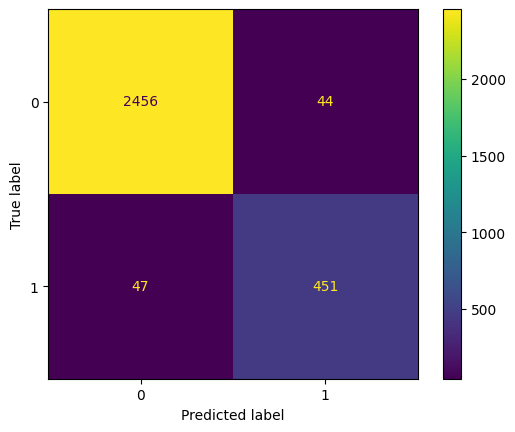

In [94]:
# Drawing a Confusion Matrix on the Testing Set Results to evaluate the model v2
y_pred = grid_rf2.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred, labels=grid_rf2.classes_)
cm_diplay = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_rf2.classes_)
cm_diplay.plot()

#### Features Importance

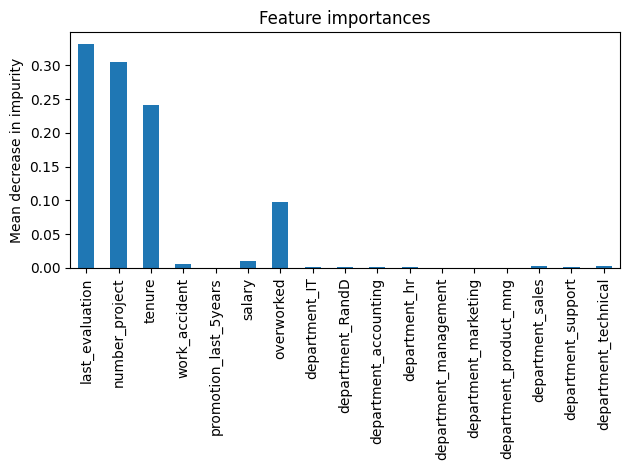

In [95]:
# Analyzing Feature importance within the model
importance = grid_rf2.best_estimator_.feature_importances_

rf_importances = pd.Series(importance, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The plot above shows that `last_evaluation`, `number_project`, `tenure`, and `overworked`, as the most important features which are variables very helpful in predicting the outcome variable `left`.

## Execute
In this last phase we will summarize how the model performed after the analysis and tweak we were able to construct and review based on the initial task.


### Summary of Model Performance

The performance of our random forest model on the testing data achieved an score of **96%** (AUC) which is prety close to the score with the training data. The random forest model also achieved a recall of **92.6%** and a precision of **97%**, before we proceeded with feature engineering. After conducting feature engineering the random forest model achieved AUC of **94%**, precision of **91%**, recall of **90%**, f1-score of **91%**, and an accuracy of **97%**, on the testing data. The random forest model outperformed both the decision tree model (modestly), and the logistic regression model (greatly).

Based on the model, `last evaluation`, `number of projects`, `tenure`, `satisfaction_level` (if available) and whether an employee was `overworked`, were the most influential features in determining if an employee is staying or leaving the company.

### Conclusion and Recommedations

The models and features importances reviewed from the models confirm that employees within Salifort Motors are overworked. To retain employees, the following recomendations could be presented to the stakeholders:

*   Limit the number of projects that employees can work on to reduce working hours.
*   Prioritize promotion for employees that have been with the company at least 4 years.
*  Choose between rewarding accordingly employees who work longer hours or don't require them to do so.
*  High evaluation for performance review should be attribute to every employee who contribute more based on results and not only for employees who worked 200+ hours per month.
*  Change in company work culture to prioritize work/life balance.

### Limitations

One of the potential limitations for this analysis in the future is the possibility to not have available the satisfaction level data, which resulted to be the most important feature according to our first model, that why we tried building the model without it to see how it would perform. On the other hand the initial dataset does not provide the differentiation between employees that was fired or quit, this feature could potentially be of interest if provided in the future.

### Future Works

If the company take actions to tackle the issues raised from this analysis, I would say it would be interesting to do another round of study to see how the behavior of the employees have changed, and depending on what new questions may be raised additional features could be very helpful.